# Seasonal forecast download and plot for one coordinate

### About

This notebook is based on "Seasonal Forecast Anomalies": https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
It was mainly modified to use daily resolution instead of monthly.
It provides a practical introduction to calculating seasonal forecast with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2023 and 6-7 monthly lead times (up to October 2023). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. 

The tutorial will then show how to interpolate in a coordinate for both the forecast and hindcast data. (The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies BORRAR?). These will be visualised as time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Download data from the CDS
* 2 - Hindcast data 
* 3 - Real-time forecasts

<br>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-single-levels">Precomputed anomalies are also available through the CDS</a>. Note these may be slightly different due to minor differences in the way they are computed (e.g. months of constant length, 30 days)  and also due to GRIB packing discretisation. <a href="https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ">See here for more detials.</a></div>

Please see here the full documentation of the [C3S Seasonal Forecast Datasets](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts%3A+datasets+documentation). This notebook introduces you to the [seasonal forecast monthly statistics](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=overview) datasets on single levels (as opposed to multiple levels in the atmosphere).

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=sf-anomalies.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install packages

In [1]:
# Install CDS API for downloading data from the CDS
#!pip install cdsapi

In [2]:
# Install cfgrib to enable us to read GRIB format files
#!conda install -c conda-forge cfgrib -y

In [4]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

In [5]:
## 1. Request data from the CDS programmatically with the CDS API

In [6]:
# Define the coordinates to interpolate to
interp_longitude=2.5
interp_latitude=41.5
#interp_latitude = 42.3
#interp_longitude = 2.25
variable_name = '2m_temperature'
var_short = 't2m'
forecast_year = 2023

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [7]:
DATADIR = '/home/daniel/Documents/intoDBP/input/Seasonal'

## 2.  Hindcast: Convert from hourly to daily data

In [11]:

month_num = 6

hind_1 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2003_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
hind_2 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2004-2014_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
hind_3 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2015-2016_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')

hind_var_1 = hind_1[var_short]
hind_var_2 = hind_2[var_short]
hind_var_3 = hind_3[var_short]

#data_array= hind_var_1
#summary_stats = {
#    'mean': data_array.mean(),
#    'min': data_array.min(),
#    'max': data_array.max(),
#    'std': data_array.std(),
#    'median': data_array.median(),
#}

# Interpolate the values for the specified coordinates
hind_interp_1 = hind_var_1.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
hind_interp_2 = hind_var_2.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
hind_interp_3 = hind_var_3.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

daily_step_1 = hind_interp_1.sizes['step']/4
daily_step_2 = hind_interp_2.sizes['step']/4
daily_step_3 = hind_interp_3.sizes['step']/4

hind_daily_1 = hind_interp_1.groupby_bins('step', bins=daily_step_1).mean()
hind_daily_2 = hind_interp_2.groupby_bins('step', bins=daily_step_2).mean()
hind_daily_3 = hind_interp_3.groupby_bins('step', bins=daily_step_3).mean()

hind_merged = xr.concat([hind_daily_1, hind_daily_2, hind_daily_3], dim='time')

/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)
/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)
/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)


#### Extract data array from dataset

The `xarray.Dataset` object into which we have read the data from the downloaded GRIB files may contain arrays of multiple variables (even if we have only one: total precipitation). Another xarray data structure, `xarray.DataArray`, facilitates operations on single variables. We will use this to further process our data. You can select the relevant DataArray from a Dataset by specifying the name of the variable (in our case `tprate`) in square brackets `[]`. 

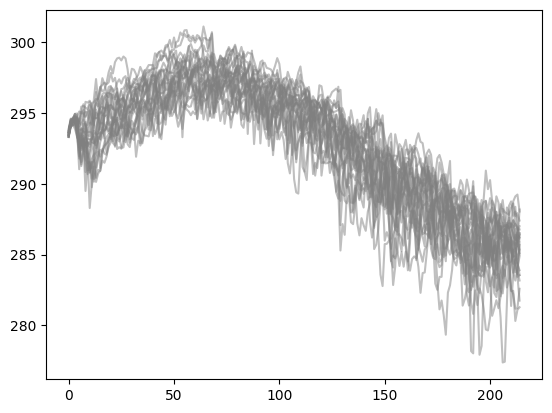

In [15]:
year_subset = '2000-' + "{:02d}".format(month_num)+ '-01T00:00:00.000000000'
subset_hind = hind_merged.sel(time=year_subset)
num_members = len(subset_hind)
subset_hind_diff = subset_hind.diff(dim='step') # by default does it along the last axis 
for i in range(num_members):
    # Select the subset of data for the current number
    subset = subset_hind_diff.sel(number=i)
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')

## 3. Run every member and year in hindcast

In [45]:
#loop here through members and years
member = 0 #0:25
year = 0 #0:24
hind_temp = hind_merged[member,year,:] #hindcast temporal

Now we should opne ERA5 to add it before the season to run the hydrological model

In [ ]:
#ADD ERA5

In [ ]:
#MERGE ERA5 WITH hind_temp

## 4.  Forecast: Convert from hourly to daily data

The next step is to load the real-time seasonal forecast data for 6 lead time months. (BORRAR?) We will then subtract the hindcast climatology from this to derive the anomalies. 


In [137]:
fore = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib', engine='cfgrib')

In [138]:
fore_var = fore[var_short]

#### Convert forecast lead time month into dates (AUN NO)


In [140]:
# Interpolate the values for the specified coordinates
fore_interp = fore_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

In [143]:
num_members = len(fore_interp)
daily_step = fore_interp.sizes['step']/4
fore_daily = fore_interp.groupby_bins('step', bins=daily_step).mean()

/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)


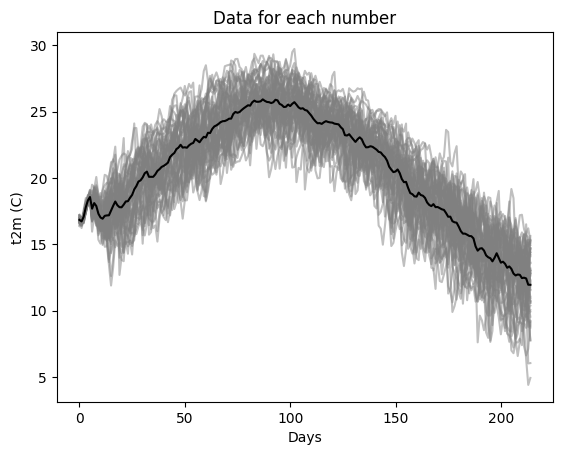

In [147]:
for i in range(num_members):
    # Select the subset of data for the current number
    subset = fore_daily.sel(number=i)-273.15
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')

#plot average in black
plt.plot(fore_daily.mean(dim='number')-273.15, color='black')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('t2m (C)')
plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()
